# Zipf-aware wave tokenization (word-level) quick viz

This notebook demo assigns per-token wave frequencies from word Zipf ranks (with per-query mixing), builds simple wave embeddings, and visualizes frequency bands and a toy attention superposition.

Steps:
1. Word-aware frequency assignment per query
2. Wave embedding preview (harmonic sin/cos)
3. Band/bucket view
4. Toy attention heatmap + entropy

Outputs are also saved as PNG under `figs/` for quick inspection.



In [1]:
import math
from pathlib import Path
from typing import List, Dict

import torch
import matplotlib.pyplot as plt
import numpy as np

# Self-contained word-aware frequency assigner (no external import)
from dataclasses import dataclass
from collections import Counter

@dataclass
class WordFreqConfig:
    vocab_size_words: int
    freq_min: float = 0.0
    freq_max: float = 1.0
    mix_weight: float = 0.7  # weight on global rank vs local rank

    def validate(self) -> bool:
        assert self.vocab_size_words > 0, "vocab_size_words must be positive"
        assert 0.0 <= self.freq_min < self.freq_max <= 1.0, "freq_min/freq_max must satisfy 0 <= min < max <= 1"
        assert 0.0 <= self.mix_weight <= 1.0, "mix_weight must be in [0,1]"
        return True

class WordFrequencyAssigner:
    def __init__(self, tokenizer, word_rank_table: Dict[str, int], config: WordFreqConfig) -> None:
        self.tokenizer = tokenizer
        self.word_rank_table = word_rank_table
        self.config = config
        self.config.validate()

    def _word_ranks(self, words: List[str]) -> List[int]:
        default_rank = self.config.vocab_size_words  # rarest fallback
        return [self.word_rank_table.get(w, default_rank) for w in words]

    def _local_ranks(self, words: List[str]) -> List[int]:
        counts = Counter(words)
        sorted_words = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
        local_rank_map = {w: i for i, (w, _) in enumerate(sorted_words, start=1)}
        return [local_rank_map[w] for w in words]

    def _mix_ranks(self, global_rank: int, local_rank: int) -> float:
        a = self.config.mix_weight
        return (global_rank ** a) * (local_rank ** (1.0 - a))

    def _rank_to_freq(self, rank: torch.Tensor) -> torch.Tensor:
        log_v = torch.log(torch.tensor(float(self.config.vocab_size_words)))
        norm = torch.log(rank) / log_v
        return self.config.freq_min + (self.config.freq_max - self.config.freq_min) * norm

    def assign(self, text: str):
        encoded = self.tokenizer.encode_plus(text, return_offsets_mapping=True, add_special_tokens=False)
        token_ids = torch.tensor(encoded["input_ids"], dtype=torch.long)
        offsets = encoded["offset_mapping"]
        words: List[str] = []
        token_to_word: List[int] = []
        prev_end = -1
        word_idx = -1
        for (start, end) in offsets:
            if start == prev_end:
                token_to_word.append(word_idx)
            else:
                word_idx += 1
                token_to_word.append(word_idx)
                words.append(text[start:end])
            prev_end = end
        global_ranks = self._word_ranks(words)
        local_ranks = self._local_ranks(words)
        eff_ranks = [self._mix_ranks(g, l) for g, l in zip(global_ranks, local_ranks)]
        rank_tensor = torch.tensor([eff_ranks[idx] for idx in token_to_word], dtype=torch.float32)
        freqs = self._rank_to_freq(rank_tensor)
        return token_ids, freqs

# Figure directory
NOTEBOOK_DIR = Path.cwd()
FIG_DIR = NOTEBOOK_DIR / "figs"
FIG_DIR.mkdir(exist_ok=True)

# Lightweight whitespace tokenizer with offsets compatible with WordFrequencyAssigner expectations
class WhiteSpaceTokenizer:
    def encode_plus(self, text: str, return_offsets_mapping=True, add_special_tokens=False):
        words = text.split()
        offsets = []
        input_ids = []
        pos = 0
        for w in words:
            start = text.find(w, pos)
            end = start + len(w)
            offsets.append((start, end))
            input_ids.append(hash(w) % 10000)  # fake token id
            pos = end
        return {"input_ids": input_ids, "offset_mapping": offsets}

# Example text and word rank table (mock Zipf ranks; 1 = most common)
text = (
    "In the old city market, a clockmaker named Elio repaired watches while listening "
    "to travelers share stories of distant storms, buried ships, and silent libraries. "
    "Each morning he brewed coffee, greeted the pigeons, and wound a brass clock that "
    "never kept perfect time but always chimed at sunset. One evening a sailor left a "
    "map drawn on brittle parchment, promising a hidden tower where books hummed like "
    "bees and gears turned pages. Elio packed tools, a lantern, and his curious heart, "
    "walking past quiet canals, over stone bridges, until dawn painted the rooftops. "
    "He found the tower wrapped in ivy, its door ajar, its staircase spiraling upward. "
    "Inside, the shelves whispered, the clocks breathed, and the pages rustled with "
    "distant thunder. Elio climbed, counted every step, and set his old brass clock on "
    "a wooden table. When the tower chimed, the clocks aligned, and the stories braided "
    "into melody, he realized time was a conversation between memory and motion."
)

# Mock global word ranks (1 = most frequent); unseen words default to rare
word_ranks: Dict[str, int] = {
    "the": 1,
    "and": 5,
    "in": 8,
    "a": 10,
    "of": 12,
    "to": 15,
    "old": 600,
    "city": 900,
    "market": 1500,
    "clockmaker": 5000,
    "elio": 8000,
    "repaired": 4000,
    "watches": 2200,
    "travelers": 3500,
    "stories": 1800,
    "distant": 2500,
    "storms": 4200,
    "buried": 4600,
    "ships": 2000,
    "silent": 2400,
    "libraries": 5200,
    "morning": 1600,
    "coffee": 1900,
    "pigeons": 7000,
    "wound": 4800,
    "brass": 3000,
    "clock": 1400,
    "perfect": 1700,
    "time": 600,
    "always": 900,
    "chimed": 2800,
    "sunset": 2600,
    "evening": 2100,
    "sailor": 3300,
    "map": 1750,
    "brittle": 5200,
    "parchment": 5201,
    "promising": 2600,
    "hidden": 2300,
    "tower": 1500,
    "books": 900,
    "hummed": 5205,
    "bees": 5206,
    "gears": 2600,
    "turned": 1900,
    "pages": 2000,
    "packed": 2100,
    "tools": 1900,
    "lantern": 4000,
    "curious": 1900,
    "heart": 1600,
    "walking": 1400,
    "past": 1100,
    "quiet": 1400,
    "canals": 5207,
    "over": 200,
    "stone": 1700,
    "bridges": 2600,
    "until": 300,
    "dawn": 2000,
    "painted": 2100,
    "rooftops": 5208,
    "found": 900,
    "wrapped": 2600,
    "ivy": 5209,
    "door": 1800,
    "ajar": 5210,
    "staircase": 5211,
    "spiraling": 5212,
    "upward": 2200,
    "inside": 1000,
    "shelves": 3000,
    "whispered": 3200,
    "clocks": 1800,
    "breathed": 5213,
    "pages": 2000,
    "rustled": 4200,
    "thunder": 2500,
    "climbed": 2400,
    "counted": 2500,
    "step": 900,
    "set": 400,
    "wooden": 1700,
    "table": 1100,
    "aligned": 2600,
    "stories": 1800,
    "braided": 5214,
    "melody": 2600,
    "realized": 1900,
    "conversation": 1500,
    "between": 300,
    "memory": 1200,
    "motion": 1800,
}

config = WordFreqConfig(vocab_size_words=60000, freq_min=0.0, freq_max=1.0, mix_weight=0.7)
tokenizer = WhiteSpaceTokenizer()
assigner = WordFrequencyAssigner(tokenizer, word_ranks, config)

token_ids, freqs = assigner.assign(text)
positions = torch.arange(len(token_ids), dtype=torch.float32)

print("Tokens:", token_ids.tolist())
print("Freqs:", freqs.tolist())



Tokens: [1998, 7702, 7793, 9426, 6947, 9320, 8184, 1389, 4040, 9424, 9455, 5022, 6849, 8916, 4199, 2236, 6822, 4720, 5656, 5211, 8446, 9993, 7431, 636, 9752, 5426, 9826, 4828, 3650, 7679, 788, 7702, 3853, 7431, 6089, 9320, 3559, 7998, 3775, 3587, 8888, 9920, 8840, 4039, 4915, 6962, 8219, 5221, 2756, 7558, 9320, 9728, 6714, 9320, 4615, 8892, 7351, 5764, 7588, 5404, 9320, 2661, 8142, 4672, 2594, 2910, 3545, 8695, 7431, 8056, 4653, 7304, 4040, 1560, 6098, 9320, 1879, 7431, 5639, 360, 6886, 7819, 4564, 2335, 7018, 4281, 3815, 6989, 3829, 6005, 6913, 7702, 2342, 9627, 7747, 7702, 8142, 3941, 4322, 8380, 6637, 3809, 3024, 6637, 5705, 4817, 6496, 5532, 7702, 1923, 2260, 7702, 370, 2541, 7431, 7702, 3249, 9421, 3791, 5656, 1273, 4040, 1547, 7557, 4822, 4090, 7431, 5319, 5639, 7793, 3559, 7998, 7351, 9320, 6685, 984, 3398, 7702, 8142, 7359, 7702, 370, 7987, 7431, 7702, 6822, 6331, 2207, 4911, 4828, 1957, 8840, 5368, 9320, 8207, 5154, 4111, 7431, 6794]
Freqs: [0.7802875638008118, 0.0, 0.47693943

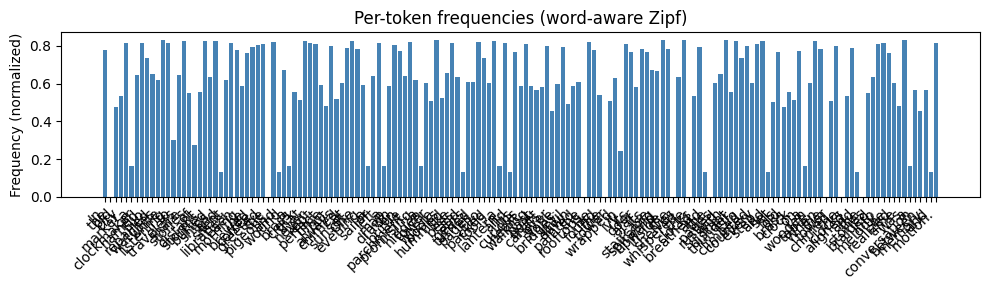

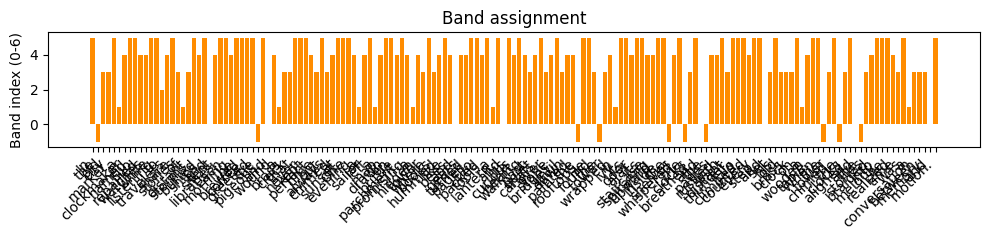

In [2]:
# Band assignment and frequency plot
words = text.split()
num_bands = 7
band_edges = torch.linspace(config.freq_min, config.freq_max, num_bands + 1)
band_ids = torch.bucketize(freqs, band_edges) - 1  # 0-based

plt.figure(figsize=(10, 3))
plt.bar(range(len(freqs)), freqs.numpy(), color="steelblue")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Frequency (normalized)")
plt.title("Per-token frequencies (word-aware Zipf)")
plt.tight_layout()
plt.savefig(FIG_DIR / "freqs.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 2.5))
plt.bar(range(len(band_ids)), band_ids.numpy(), color="darkorange")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Band index (0-6)")
plt.title("Band assignment")
plt.tight_layout()
plt.savefig(FIG_DIR / "bands.png", dpi=150)
plt.show()



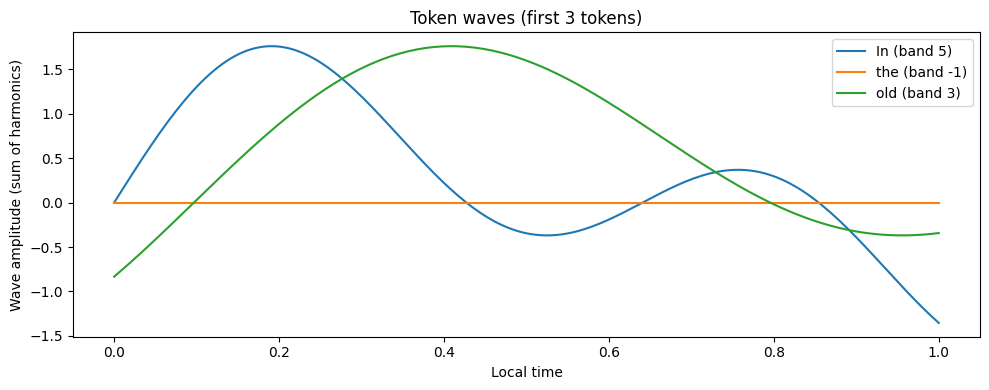

In [3]:
# Wave embedding preview (simple sin/cos, 2 harmonics)
harmonics = torch.arange(1, 3, dtype=torch.float32)

t_local = torch.linspace(0, 1, 200)
plt.figure(figsize=(10, 4))
for i in range(min(3, len(freqs))):
    f = freqs[i]
    p = positions[i]
    wave = 0
    for h in harmonics:
        wave = wave + torch.sin(2 * math.pi * f * h * (p + t_local))
    plt.plot(t_local.numpy(), wave.numpy(), label=f"{words[i]} (band {band_ids[i].item()})")
plt.xlabel("Local time")
plt.ylabel("Wave amplitude (sum of harmonics)")
plt.title("Token waves (first 3 tokens)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "waves.png", dpi=150)
plt.show()



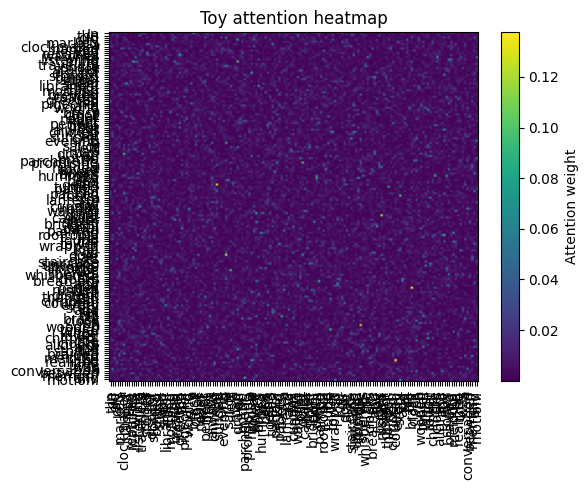

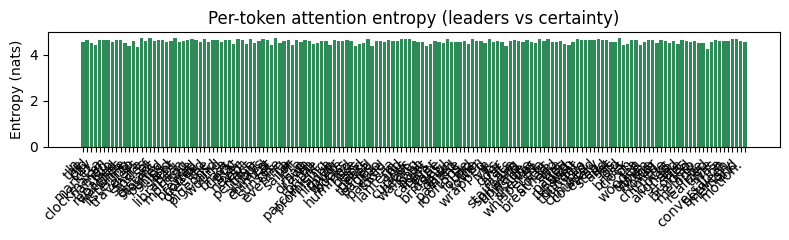

In [4]:
# Toy attention superposition and entropy
seq_len = len(freqs)
logits = torch.randn(seq_len, seq_len)
attn = torch.softmax(logits, dim=-1)

entropy = -(attn * (attn.clamp(min=1e-9).log())).sum(dim=-1)

plt.figure(figsize=(6, 5))
plt.imshow(attn.numpy(), cmap="viridis", aspect="auto")
plt.colorbar(label="Attention weight")
plt.xticks(range(seq_len), words, rotation=90)
plt.yticks(range(seq_len), words)
plt.title("Toy attention heatmap")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_heatmap.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 2.5))
plt.bar(range(seq_len), entropy.numpy(), color="seagreen")
plt.xticks(range(seq_len), words, rotation=45, ha="right")
plt.ylabel("Entropy (nats)")
plt.title("Per-token attention entropy (leaders vs certainty)")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_entropy.png", dpi=150)
plt.show()

